In [9]:
import geopandas as gpd
import pandas as pd
from shapely import wkt
from osgeo import gdal, osr, ogr  # necessario intalar a whell manualmente https://www.lfd.uci.edu/~gohlke/pythonlibs/
import platform
print(platform.system(),)
print(platform.machine(),)
print(platform.platform(),)
print(platform.uname(),)
print(platform.version(),)
print(platform.mac_ver(),)
import math
import time
import pyproj
import random
from shapely.geometry import LineString, CAP_STYLE
from PIL import Image
import PIL.Image
import matplotlib.pyplot as plt
import mercantile
from cores import *
#import rasterio
#from rasterio import features

Windows
AMD64
Windows-10-10.0.19045-SP0
uname_result(system='Windows', node='C118', release='10', version='10.0.19045', machine='AMD64')
10.0.19045
('', ('', '', ''), '')


In [10]:
file = 'gpd.csv'

MERCATOR = pyproj.CRS('epsg:3857')
WGS84 = pyproj.CRS('epsg:4326')
SAD1969  = pyproj.CRS('esri:102033')

df = pd.read_csv(file)

df = df.loc[(df.cor != 'humidity_rastro') & (df.cor != 'produzindo_rastro')]
df = df.drop(['Unnamed: 0'], axis = 1)
df.cor = df.cor.str.capitalize()

df['geometry'] = df['geometry'].apply(wkt.loads)
gdf = gpd.GeoDataFrame(df, crs=WGS84)

application_color_list = ['App_L3', 'App_L2', 'App_L1', 'App_0', 'App_H1', 'App_H2', 'App_H3']
camada_objeto = 'App_rastro'
if len(gdf[gdf['cor'] == camada_objeto]['value'].dropna().unique()) > 1:
    print("Tiles - processar polígonos de velocidade")
    inicial = gdf[gdf['cor'] == camada_objeto]['value'].dropna().quantile(0.1)
    final = gdf[gdf['cor'] == camada_objeto]['value'].dropna().quantile(0.9)
    topo = gdf[gdf['cor'] == camada_objeto]['value'].dropna().quantile(1)
    n_intervalos = 7
    passo = (final - inicial) / (n_intervalos - 2)
    atual = inicial
    intervalos = []
    intervalos.append([0, inicial])
    for i in list(range(2, n_intervalos)):
        intervalos.append([atual, atual + passo])
        atual = atual + passo
    intervalos.append([final, topo + 1])
    pos_int = 0
    for intervalo in intervalos:
        gdf.loc[(gdf['cor'] == camada_objeto) & (gdf['value'] >= intervalo[0]) & (gdf['value'] < intervalo[1]), 'cor'] = application_color_list[pos_int]
        pos_int = pos_int + 1
gdf = gdf.reset_index(drop=True)


gdf = gdf.to_crs(MERCATOR)
mask =[]
for i in gdf.geometry: 
    mask.append(type(i)==type(gdf.geometry.loc[0]))
gdf.geometry.loc[mask] = gdf.geometry.loc[mask].buffer(1,  cap_style=CAP_STYLE.square)

source = ogr.Open(gdf.to_crs(WGS84).to_json())

#gdf


Tiles - processar polígonos de velocidade


In [11]:
source_ds = ogr.GetDriverByName("Memory").CopyDataSource(source, "")
source_layer = source_ds.GetLayer(0)
source_srs = source_layer.GetSpatialRef()
x_min, x_max, y_min, y_max = source_layer.GetExtent()
numFeatures = source_layer.GetFeatureCount()



source_layer.CreateField(ogr.FieldDefn('Red', ogr.OFTReal))
source_layer.CreateField(ogr.FieldDefn('Green', ogr.OFTReal))
source_layer.CreateField(ogr.FieldDefn('Blue', ogr.OFTReal))


source_layer_def = source_layer.GetLayerDefn()
fd_id = source_layer_def.GetFieldIndex('cor')
r_id = source_layer_def.GetFieldIndex('Red')
g_id = source_layer_def.GetFieldIndex('Green')
b_id = source_layer_def.GetFieldIndex('Blue')


ldefn = source_layer.GetLayerDefn()
ldefn.GetFieldCount()
lsAtribNames = [field.name for field in source_layer.schema]

In [12]:
for feature in source_layer:
    feature.SetField(r_id,globals()[feature.GetField(fd_id)][0])
    source_layer.SetFeature(feature)
for feature in source_layer:
    feature.SetField(g_id,globals()[feature.GetField(fd_id)][1])
    source_layer.SetFeature(feature)
for feature in source_layer:
    feature.SetField(b_id,globals()[feature.GetField(fd_id)][2])
    source_layer.SetFeature(feature)

In [13]:
pix_size = 0.000002
x_res = int((x_max - x_min) / pix_size)
y_res = int((y_max - y_min) / pix_size)
x_res, y_res

(331, 1536)

In [14]:
target_ds = gdal.GetDriverByName('MEM').Create('', x_res, y_res, 4, gdal.GDT_Byte)
target_ds.SetGeoTransform((x_min, pix_size, 0, y_max, 0, -pix_size))

proj = 'PROJCS["unnamed",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["EPSG:4326"],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","4326"]]'

if source_srs:
    target_ds.SetProjection(source_srs.ExportToWkt())
else:
    target_ds.SetProjection(proj)

#err = gdal.RasterizeLayer(target_ds, [1,2,3], source_layer, burn_values=(0xff, 0xff, 0xff))

err = gdal.RasterizeLayer(target_ds, [1], source_layer, options=["ATTRIBUTE=%s" % 'Red'])
err = gdal.RasterizeLayer(target_ds, [2], source_layer, options=["ATTRIBUTE=%s" % 'Green'])
err = gdal.RasterizeLayer(target_ds, [3], source_layer, options=["ATTRIBUTE=%s" % 'Blue'])
err = gdal.RasterizeLayer(target_ds, [4], source_layer, burn_values=[0xff])



""" pngdriver = gdal.GetDriverByName('PNG')
pngdriver.CreateCopy('rasterize.png', target_ds) """


" pngdriver = gdal.GetDriverByName('PNG')\npngdriver.CreateCopy('rasterize.png', target_ds) "

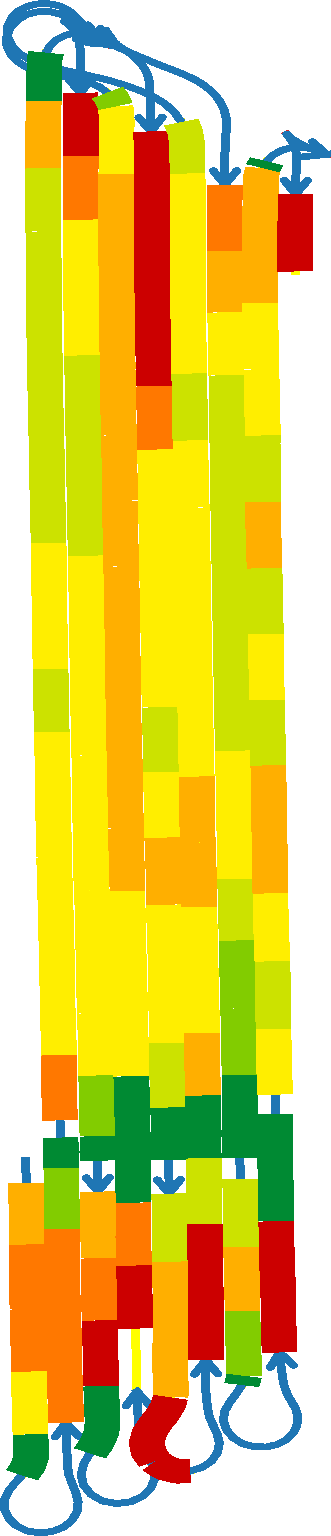

In [17]:
img = Image.fromarray(target_ds.ReadAsArray().transpose(), mode="RGBA").rotate(90, expand=True).transpose(PIL.Image.FLIP_TOP_BOTTOM)
img

In [16]:
size_tile = 256
filename_int = 'COMBINE_D8A01D55C8C6_220928_231502_80_RAW'
mac_int = 'D8A01D55C8C6'
ano_int = '22'
mes_int = '09'
dia_int = '28'
hora_e_minuto_int = '2315'

z_int = 8 até 19
teste_S_linha_int = '180'
layer_terminator = {'_0': 'tiles_track', '_1': 'tiles_app_rate', '_2': 'tiles_speed', '_3': 'tiles_overlap', '_4': 'tiles_yield', '_5': 'tiles_humidity', '_6': 'tiles_quality'}
layer_terminator = '_0'

arquivos_gerados = []

def processa_tiles(itens_t_x_int,itens_t_y_int, img_buffer, size_tile_int, filename_int, mac_int, ano_int, mes_int, dia_int, hora_e_minuto_int, z_int, teste_S_linha_int, layer_terminator, arquivos_gerados_int):
    soma_bytes = np.asarray(img_buffer, dtype="int64").sum()
    soma_tamanho = img_buffer.size[0] * img_buffer.size[1] * (255 * 4)
    if (soma_bytes == soma_tamanho):
        print('Tiles - Skip portion')
        return arquivos_gerados_int

    for cnt_x in range(0, len(itens_t_x_int)):
        for cnt_y in range(0, len(itens_t_y_int)):
            box = (size_tile_int * cnt_x, size_tile_int * cnt_y, size_tile_int * (cnt_x + 1), size_tile_int * (cnt_y + 1))
            area = img_buffer.crop(box)
            ##Descarta a imagem inteira branca
            #marca_tempo1 = time.time()
            soma_bytes = np.asarray(area, dtype="int32").sum()
            soma_tamanho = size_tile_int * size_tile_int * (255 * 4)
            #marca_tempo2 = time.time()
            if (soma_bytes != soma_tamanho):
                #marca_tempo3 = time.time()
                # Satura o S da imagem em HSV
                im_HSV = area.convert('HSV')
                data_hsv = np.array(im_HSV)
                S = data_hsv[:, :, 1]
                S_saturado = []
                for S_linha in S:
                    S_saturado.append(np.where(S_linha > teste_S_linha_int, 255, S_linha))
                data_hsv[:, :, 1] = S_saturado
                # Converte a imagem HSV para RGBA
                im_HSV = Image.fromarray(data_hsv, mode="HSV")
                im_RGBA = im_HSV.convert("RGBA")
                # Copia o S do HSV para o RGBA
                data = np.array(im_RGBA)
                data[:, :, 3] = data_hsv[:, :, 1]
                im_RGBA = Image.fromarray(data)
                Path(os.path.join(pasta_tiles, filename_int, mac_int, ano_int, mes_int, dia_int, str(z_int),str(itens_t_x_int[cnt_x]), str(itens_t_y_int[cnt_y]))).mkdir(parents=True,exist_ok=True)
                nome_arquivo = os.path.join(pasta_tiles, filename_int, mac_int, ano_int, mes_int, dia_int,str(z_int), str(itens_t_x_int[cnt_x]), str(itens_t_y_int[cnt_y]),hora_e_minuto_int + layer_terminator + ".png")
                im_RGBA.save(nome_arquivo)
                arquivos_gerados_int.append(TileFile(z_int, nome_arquivo))
                #marca_tempo4 = time.time()
                #print("Tempo de processamento 2: " + str(marca_tempo4 - marca_tempo3))
            #else:
                #print("Tempo de processamento 1: " + str(marca_tempo2-marca_tempo1))
    return arquivos_gerados_int



for z in range(self.zoom_min, (self.zoom_max + 1)):
    print('###################################')
    print("Zoom: " + str(z))
    print('###################################')

    t_x = []
    t_y = []

    total_bounds = self.gpd_series['geometry'].total_bounds

    # for tile in mercantile.tiles(df_lt_lo_md['longitude'].min(), df_lt_lo_md['latitude'].min(),
    #                             df_lt_lo_md['longitude'].max(), df_lt_lo_md['latitude'].max(), z):
    for tile in mercantile.tiles(total_bounds[0], total_bounds[1], total_bounds[2], total_bounds[3], z):
        t_x.append(tile.x)
        t_y.append(tile.y)
    zoom_map = z

    itens_t_x = list(sorted(list(set(t_x))))
    itens_t_y = list(sorted(list(set(t_y))))
    print('Numero de tiles: ' + str(len(itens_t_x) * len(itens_t_y)))

    # Testa para ver se a imagem não é gigante!!!
    if (len(itens_t_x) * len(itens_t_y)) > 20000:
        print(
            "Não é possível gerar as imagens para o zoom: {} Imagem muito grande!, parando execução".format(
                str(z)))
        break
    # Testa para ver se o mapa abrange todos os tiles
    if ((4 ** (z - 4) * 256) == (len(itens_t_x) * len(itens_t_y))):
        print("Não é possível gerar as imagens para o zoom: {} Engloba todos os tiles".format(str(z)))
        break

    lista_itens_t_x = []
    lista_itens_t_y = []

    while len(itens_t_x) > 0:
        if len(itens_t_x) > porcao:
            lista_itens_t_x.append(itens_t_x[0:porcao])
            del itens_t_x[0:porcao]
        else:
            lista_itens_t_x.append(itens_t_x)
            itens_t_x = []

    while len(itens_t_y) > 0:
        if len(itens_t_y) > porcao:
            lista_itens_t_y.append(itens_t_y[0:porcao])
            del itens_t_y[0:porcao]
        else:
            lista_itens_t_y.append(itens_t_y)
            itens_t_y = []

    contador_teste = 0
    for temp_lista_itens_t_x in lista_itens_t_x:
        for temp_lista_itens_t_y in lista_itens_t_y:
            contador_teste = contador_teste + 1
            itens_t_x = temp_lista_itens_t_x
            itens_t_y = temp_lista_itens_t_y

            size_x = len(itens_t_x) * 256
            size_y = len(itens_t_y) * 256

            # print(str(size_x) +"x" + str(size_y))

            t_x_min = itens_t_x[0]
            t_x_max = itens_t_x[-1]
            t_y_min = itens_t_y[0]
            t_y_max = itens_t_y[-1]

            lat_min = mercantile.bounds(mercantile.Tile(x=t_x_min, y=t_y_min, z=z))[3]
            lat_max = mercantile.bounds(mercantile.Tile(x=t_x_max, y=t_y_max, z=z))[1]
            lon_min = mercantile.bounds(mercantile.Tile(x=t_x_min, y=t_y_min, z=z))[0]
            lon_max = mercantile.bounds(mercantile.Tile(x=t_x_max, y=t_y_max, z=z))[2]

            fig.update_layout(
                width=size_x,
                height=size_y,
                showlegend=False,
                coloraxis_showscale=False,
                margin={"r": 0, "t": 0, "l": 0, "b": 0},
                mapbox_style="white-bg",
                mapbox={'center': {'lat': (lat_min + lat_max) / 2, 'lon': (lon_min + lon_max) / 2},
                        'zoom': zoom_map - 1}
            )

            if processa_isobus == False:
                if gera_rastros == False:
                    print("Somente caminhos")
                else:
                    print("Rastros Sem Isobus")
            else:
                print("Isobus")

            if z == 18:
                print('parar')

            #Somente trajetos
            processa_tiles_flag = False
            for trace in dic_name_pos:
                # print(dic_name_pos[trace])
                if (ignorar_rastro_zoom_baixo == True) and (z <= 17):
                    traces_to_keep_trajetos_temp = list(set(traces_to_keep_trajetos) - {'produzindo'})
                else:
                    traces_to_keep_trajetos_temp = traces_to_keep_trajetos

                if trace in traces_to_keep_trajetos_temp:
                    fig.data[dic_name_pos[trace]].visible = True
                    processa_tiles_flag = True
                else:
                    fig.data[dic_name_pos[trace]].visible = False
            if processa_tiles_flag:
                temp_file_name = os.path.join(pasta_tiles, self.filename, self.filename + '_' + str(z) + "_0_temp.png")
                #img = Image.open(io.BytesIO(pio.to_image(fig)))
                #img.save(temp_file_name)
                fig.write_image(temp_file_name)
                img = Image.open(temp_file_name)
                arquivos_gerados = self.processa_tiles(itens_t_x, itens_t_y, img, size_tile, self.filename,mac, ano, mes, dia, hora_e_minuto, z, teste_S_linha, '_0', arquivos_gerados)
                img.close()


            ## Taxa de Aplicação
            processa_tiles_flag = False
            for trace in dic_name_pos:
                # print(dic_name_pos[trace])
                if trace in traces_to_keep_application:
                    fig.data[dic_name_pos[trace]].visible = True
                    processa_tiles_flag = True
                else:
                    fig.data[dic_name_pos[trace]].visible = False
            if processa_tiles_flag:
                temp_file_name = os.path.join(pasta_tiles, self.filename, self.filename + '_' + str(z) + "_1_temp.png")
                #img = Image.open(io.BytesIO(pio.to_image(fig)))
                #img.save(temp_file_name)
                fig.write_image(temp_file_name)
                img = Image.open(temp_file_name)
                arquivos_gerados = self.processa_tiles(itens_t_x, itens_t_y, img, size_tile, self.filename,mac, ano, mes, dia, hora_e_minuto, z, teste_S_linha, '_1', arquivos_gerados)
                img.close()

            ## Rastros de velocidade
            processa_tiles_flag = False
            for trace in dic_name_pos:
                if trace in traces_to_keep_velocity:
                    fig.data[dic_name_pos[trace]].visible = True
                    processa_tiles_flag = True
                else:
                    fig.data[dic_name_pos[trace]].visible = False
            if processa_tiles_flag:
                temp_file_name = os.path.join(pasta_tiles, self.filename, self.filename + '_' + str(z) + "_2_temp.png")
                fig.write_image(temp_file_name)
                img = Image.open(temp_file_name)
                arquivos_gerados = self.processa_tiles(itens_t_x, itens_t_y, img, size_tile, self.filename,mac, ano, mes, dia, hora_e_minuto, z, teste_S_linha, '_2', arquivos_gerados)
                img.close()

            ## Rastros de umidade
            processa_tiles_flag = False
            for trace in dic_name_pos:
                if trace in traces_to_keep_humidity:
                    fig.data[dic_name_pos[trace]].visible = True
                    processa_tiles_flag = True
                else:
                    fig.data[dic_name_pos[trace]].visible = False
            if processa_tiles_flag:
                temp_file_name = os.path.join(pasta_tiles, self.filename, self.filename + '_' + str(z) + "_5_temp.png")
                fig.write_image(temp_file_name)
                img = Image.open(temp_file_name)
                arquivos_gerados = self.processa_tiles(itens_t_x, itens_t_y, img, size_tile, self.filename,mac, ano, mes, dia, hora_e_minuto, z, teste_S_linha, '_5', arquivos_gerados)
                img.close()


SyntaxError: invalid syntax (3134893614.py, line 9)